In [4]:
import os
import wfdb
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Flatten, concatenate, Attention, Layer
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter

# --- 1. Data Preprocessing and Integration ---
PTB_PATH = 'physionet.org/content/ptbdb/1.0.0' 

def load_ecg_and_clinical_data(record_path):
    """Loads ECG and clinical data from a single record."""
    signals, fields = wfdb.rdsamp(record_path)

    # Extract age and handle potential errors or missing values
    try:
        age_str = fields['comments'][0].split(" ")[-1]
        age = int(age_str) 
    except (IndexError, ValueError):
        age = np.nan  # Set to NaN if age cannot be extracted

    sex = fields['comments'][1].split(":")[-1].strip() if 'Sex' in fields['comments'][1] else np.nan

    diagnosis = 'unknown'  
    additional_diagnosis = 'unknown'
    smoker = 'unknown'
    in_hospital_medication = 'unknown'

    for line in fields['comments']:
        if 'Reason for admission:' in line:
            diagnosis = line.split(":")[-1].strip().lower()
        if 'Additional diagnoses:' in line:
            additional_diagnosis = line.split(":")[-1].strip().lower()
        if 'Smoker:' in line:
            smoker = line.split(":")[-1].strip().lower()
        if 'In hospital medication:' in line:
            in_hospital_medication = line.split(":")[-1].strip().lower()

    # Replace "n/a" with "unknown"
    diagnosis = diagnosis.replace("n/a", "unknown")
    additional_diagnosis = additional_diagnosis.replace("n/a", "unknown")
    smoker = smoker.replace("n/a", "unknown")
    in_hospital_medication = in_hospital_medication.replace("n/a", "unknown")

    return signals, age, sex, diagnosis, additional_diagnosis, smoker, in_hospital_medication 

# (a) ECG Signal Processing: 
def preprocess_ecg(signals, sampling_rate=1000):
    """Applies preprocessing steps to ECG signals."""
    from scipy.signal import butter, lfilter, iirnotch

    # 1. Baseline Wander Removal: (Using a bandpass filter)
    nyquist = 0.5 * sampling_rate
    low_cutoff = 0.5 
    high_cutoff = 40 
    low = low_cutoff / nyquist
    high = high_cutoff / nyquist
    b, a = butter(4, [low, high], btype='band')
    filtered_signals = lfilter(b, a, signals, axis=0)  

    # 2. Powerline Noise Removal: (Using a notch filter)
    f0 = 50  
    Q = 30   
    b, a = iirnotch(f0, Q, sampling_rate)
    filtered_signals = lfilter(b, a, filtered_signals, axis=0)

    # 3. Normalization:
    normalized_signals = (filtered_signals - np.mean(filtered_signals, axis=0)) / np.std(filtered_signals, axis=0)
    
    return normalized_signals

# (b) Clinical Data Processing:
def create_clinical_df(record_names):
    patient_data = []
    for record_name in record_names:
        record_path = os.path.join(PTB_PATH, record_name)
        _, age, sex, diagnosis, additional_diagnosis, smoker, in_hospital_medication = load_ecg_and_clinical_data(record_path)
        patient_data.append([record_name, age, sex, diagnosis, additional_diagnosis, smoker, in_hospital_medication])

    df = pd.DataFrame(patient_data, columns=['record_name', 'age', 'sex', 'diagnosis', 'additional_diagnosis', 'smoker', 'in_hospital_medication'])
    
    # Normalize Age:
    df['age'] = (df['age'] - df['age'].mean()) / df['age'].std()

    # Ensure 'Unknown' is included in the categorical columns before one-hot encoding:
    for col in ['diagnosis', 'additional_diagnosis', 'smoker', 'in_hospital_medication']:
        all_values = df[col].unique().tolist()
        if 'unknown' not in all_values:
            all_values.append('unknown')
        
        # One-hot encode the column (keep all columns)
        df = pd.get_dummies(df, columns=[col]) 

        # Add missing columns if any:
        for val in all_values:
            if f'{col}_{val}' not in df.columns:
                df[f'{col}_{val}'] = 0

    return df

# Determine the number of classes and create feature maps:
record_names = [os.path.join(folder, file.replace('.hea', '')) 
                 for folder in os.listdir(PTB_PATH) if os.path.isdir(os.path.join(PTB_PATH, folder)) 
                 for file in os.listdir(os.path.join(PTB_PATH, folder)) if file.endswith('.hea')]

clinical_df = create_clinical_df(record_names) 
num_classes = len([col for col in clinical_df.columns if 'diagnosis_' in col]) 

# Create dictionaries to map feature values to indices:
feature_maps = {}
for col in ['diagnosis', 'additional_diagnosis', 'smoker', 'in_hospital_medication']:
    feature_maps[col] = {value: i for i, value in enumerate(clinical_df.columns[clinical_df.columns.str.startswith(f'{col}_')])} 

# (c) Data Integration:
def create_dataset(ptb_path, window_size=2, overlap=0.5):
    all_segments = []
    all_labels = []
    patient_diagnoses = {} 

    for patient_folder in tqdm(os.listdir(ptb_path), desc="Processing Patients"):
        patient_path = os.path.join(ptb_path, patient_folder)
        if os.path.isdir(patient_path):
            patient_records = []
            for record_file in os.listdir(patient_path):
                if record_file.endswith('.hea'):
                    record_name = record_file.replace('.hea', '')
                    record_path = os.path.join(patient_path, record_name)
                    patient_records.append(record_path)

            # Get most frequent diagnosis for the patient 
            diagnoses = [load_ecg_and_clinical_data(record)[3] for record in patient_records]
            most_common_diagnosis = Counter(diagnoses).most_common(1)[0][0]
            patient_diagnoses[patient_folder] = most_common_diagnosis

            # Process ECG segments 
            for record_path in tqdm(patient_records, desc="Processing Records", leave=False):
                signals, age, sex, diagnosis, additional_diagnosis, smoker, in_hospital_medication = load_ecg_and_clinical_data(record_path)
                processed_signals = preprocess_ecg(signals)

                _, fields = wfdb.rdsamp(record_path)
                sampling_rate = fields['fs']
                step = int(window_size * (1 - overlap) * sampling_rate)
                for i in range(0, len(processed_signals) - window_size * sampling_rate + 1, step):
                    segment = processed_signals[i:i + window_size * sampling_rate, :]
                    all_segments.append(segment)

                    # --- Create label vector --- 
                    label = [age, 1 if sex == 'male' else 0]

                    # --- DATA VERIFICATION ---
                    #print("Label before one-hot:", label) 

                    # One-hot encode clinical features
                    for col in ['diagnosis', 'additional_diagnosis', 'smoker', 'in_hospital_medication']:
                        value = eval(col)

                        feature_onehot = [0] * len(feature_maps[col])
                        
                        if f'{col}_{value}' in feature_maps[col]:
                            feature_index = feature_maps[col][f'{col}_{value}']
                            feature_onehot[feature_index] = 1
                        else:
                            print(f"Warning: {col} '{value}' not found in feature map for record {record_name}")

                        label.extend(feature_onehot)

                    #print("Label after one-hot:", label) # --- DATA VERIFICATION ---

                    all_labels.append(label)

    # --- DATA VERIFICATION --- 
    print("Shape of X (ECG segments):", np.array(all_segments).shape)
    print("Shape of y (labels):", np.array(all_labels).shape)

    return np.array(all_segments), np.array(all_labels), patient_diagnoses

HeaderSyntaxError: invalid syntax in record line

In [2]:
# --- 2. Multi-modal Model Architecture ---
def build_multimodal_model(input_shape_ecg, input_shape_clinical, num_classes):
    # --- Custom Layer for Weighted Sum ---
    class WeightedSum(Layer):
        def __init__(self, axis, **kwargs):
            super(WeightedSum, self).__init__(**kwargs)
            self.axis = axis

        def call(self, inputs):
            attention_weights, lstm_output = inputs
            return tf.reduce_sum(attention_weights * lstm_output, axis=self.axis)

    # --- ECG Branch ---
    input_ecg = Input(shape=input_shape_ecg, name='ecg_input')
    conv1 = Conv1D(filters=64, kernel_size=5, activation='relu')(input_ecg) 
    lstm1 = LSTM(units=64, return_sequences=True)(conv1)
    attention_weights = Attention()([lstm1, lstm1]) 

    # Apply the custom layer
    context_vector = WeightedSum(axis=1)([attention_weights, lstm1])
    ecg_features = Flatten()(context_vector)

    # --- Clinical Data Branch ---
    input_clinical = Input(shape=(input_shape_clinical,), name='clinical_input') # Corrected shape
    dense1 = Dense(32, activation='relu')(input_clinical)
    clinical_features = Dense(16, activation='relu')(dense1) 

    # --- Fusion Module ---
    fused_features = concatenate([ecg_features, clinical_features]) 

    # --- Output Layers ---
    output_classification = Dense(num_classes, activation='softmax', name='classification_output')(fused_features)
    output_risk = Dense(1, activation='sigmoid', name='risk_output')(fused_features)

    model = tf.keras.Model(inputs=[input_ecg, input_clinical], 
                           outputs=[output_classification, output_risk])
    return model



In [3]:
# --- Example Usage ---
window_size_seconds = 2 
overlap_ratio = 0.5       
X, y, patient_diagnoses = create_dataset(PTB_PATH, window_size_seconds, overlap_ratio)

input_shape_ecg = (X.shape[1], X.shape[2])
input_shape_clinical = y.shape[1] - 2 # Only age and sex + others


Processing Patients: 100%|██████████| 296/296 [00:38<00:00,  7.68it/s]


Shape of X (ECG segments): (58972, 2000, 15)
Shape of y (labels): (58972, 247)


In [4]:

model = build_multimodal_model(input_shape_ecg, input_shape_clinical, num_classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ecg_input           │ (None, 2000, 15)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1996, 64)  │      4,864 │ ecg_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 1996, 64)  │     33,024 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 1996, 64)  │          0 │ lstm[0][0],       │
│ (Attention)         │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clinical_input      │ (None, 245)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ weighted_sum        │ (None, 64)        │          0 │ attention[0][0],  │
│ (WeightedSum)       │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      7,872 │ clinical_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 64)        │          0 │ weighted_sum[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16)        │        528 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 80)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification_out… │ (None, 151)       │     12,231 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ risk_output (Dense) │ (None, 1)         │         81 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 58,600 (228.91 KB)

 Trainable params: 58,600 (228.91 KB)

 Non-trainable params: 0 (0.00 B)

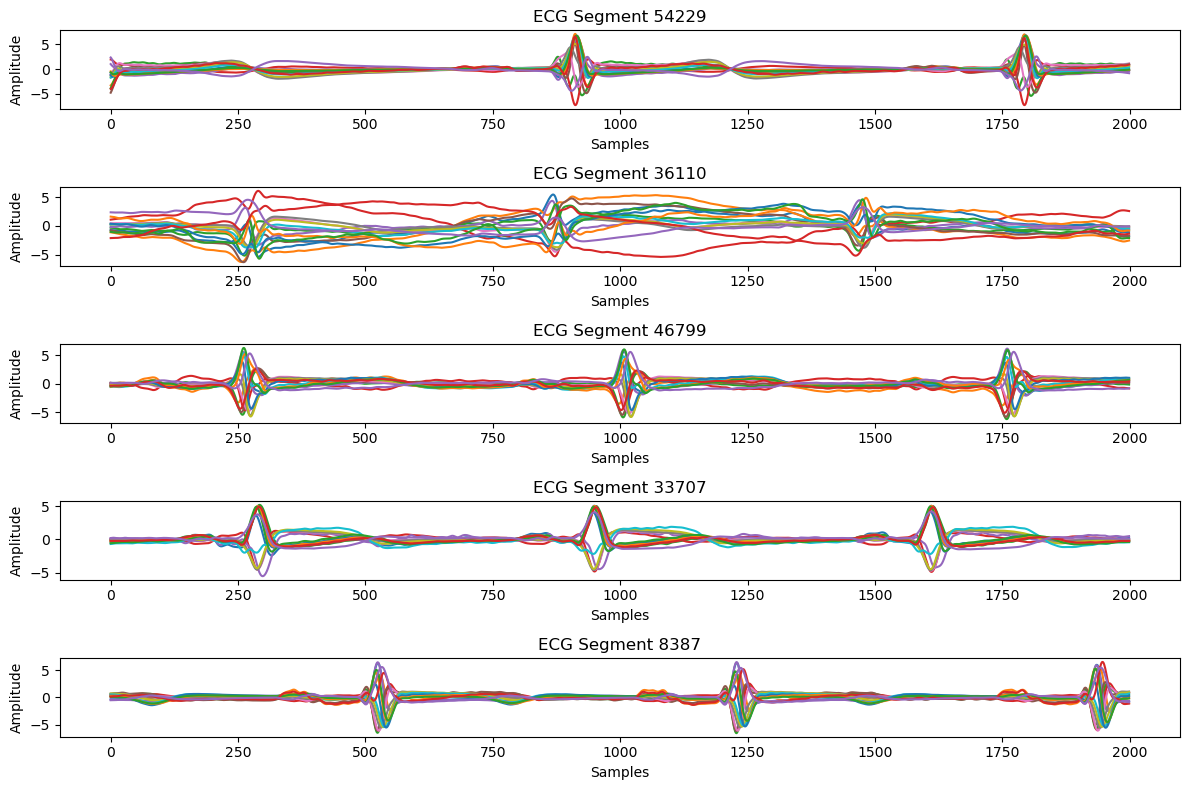

Distribution of Diagnoses:
diagnosis_bundle branch block                                                                                                                                          1902.0
diagnosis_cardiomyopathy                                                                                                                                               1844.0
diagnosis_dysrhythmia                                                                                                                                                  1261.0
diagnosis_healthy control                                                                                                                                              9355.0
diagnosis_heart failure (nyha 2)                                                                                                                                         37.0
                                                                                                       

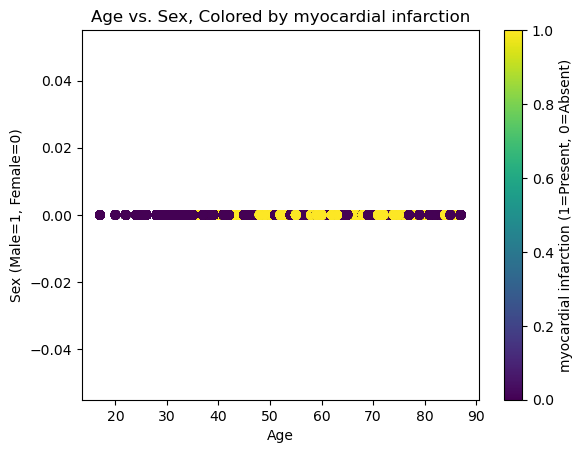

In [5]:
import matplotlib.pyplot as plt

# --- Visualize ECG Data (X) ---
# Plot a few random ECG segments
num_plots = 5 
random_indices = np.random.choice(len(X), size=num_plots, replace=False)

plt.figure(figsize=(12, 8))
for i, idx in enumerate(random_indices):
    plt.subplot(num_plots, 1, i + 1)
    plt.plot(X[idx])
    plt.title(f"ECG Segment {idx}")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

# --- Analyze Labels (y) ---
# 1. Distribution of Diagnoses
df_labels = pd.DataFrame(y, columns=[
    'age', 'sex_Male', 
    *feature_maps['diagnosis'].keys(),
    *feature_maps['additional_diagnosis'].keys(),
    *feature_maps['smoker'].keys(),
    *feature_maps['in_hospital_medication'].keys()
])

print("Distribution of Diagnoses:")
print(df_labels[[col for col in df_labels.columns if 'diagnosis_' in col]].sum())

# 2. Scatter Plot 
plt.figure()
diagnosis_to_color = 'myocardial infarction' 
diagnosis_column_name = f'diagnosis_{diagnosis_to_color}'

plt.scatter(df_labels['age'], df_labels['sex_Male'], 
            c=df_labels[diagnosis_column_name], cmap='viridis') 

plt.xlabel("Age")
plt.ylabel("Sex (Male=1, Female=0)")
plt.title(f"Age vs. Sex, Colored by {diagnosis_to_color}")
plt.colorbar(label=f"{diagnosis_to_color} (1=Present, 0=Absent)")
plt.show()